In [ ]:
from google.colab import drive

# mount drive
drive.mount('/content/drive')

# go to the folder where your dataset is stored
%cd /content/drive/My Drive/Colab Notebooks/AI_in_BE_Python_Labs/Final_Project_Data

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/AI_in_BE_Python_Labs/Final_Project_Data


In [ ]:
# Cell 1: Imports (Colab already has these installed in most cases)

import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [ ]:
# Cell 2: AMI Classes
# - AMILoader: load and clean AMI data
# - AMIFeatures: compute base load, daily avg, peak, etc.
# - AMIGraphs: basic visualizations

class AMILoader:
    """
    Loads and cleans AMI interval data that looks like:

    Row 0:  Account #...
    Row 1:  Meter #...
    Row 2:  Device Location...
    Row 3:  Date & Time    KWH Used
    Row 4+: 08/20/2025 00:15 EDT    0.599

    This class:
    - skips metadata rows
    - fixes timestamp strings and "24:00" times
    - converts kWh to numeric
    """

    def __init__(self, filename):
        self.filename = filename
        self.df = None

    def load_and_clean(self):
        # Load with header on row 3 ("Date & Time", "KWH Used")
        header_row = 3
        df = pd.read_excel(self.filename, header=header_row)

        # Standardize column names
        df.columns = ["timestamp", "kwh_used"]

        # Remove timezone suffix like " EDT"
        df["timestamp"] = df["timestamp"].astype(str).str.replace(" EDT", "", regex=False)

        # Fix "24:00" timestamps and parse
        def fix_24(ts):
            ts = str(ts)
            if "24:00" in ts:
                base = ts.replace("24:00", "00:00")
                dt = pd.to_datetime(base, format="%m/%d/%Y %H:%M", errors="coerce")
                return dt + timedelta(days=1)
            return pd.to_datetime(ts, format="%m/%d/%Y %H:%M", errors="coerce")

        df["timestamp"] = df["timestamp"].apply(fix_24)

        # Convert usage to numeric
        df["kwh_used"] = pd.to_numeric(df["kwh_used"], errors="coerce")

        # Drop invalid rows
        df = df.dropna(subset=["timestamp", "kwh_used"])
        df = df.sort_values("timestamp").reset_index(drop=True)

        self.df = df
        return df


class AMIFeatures:
    """
    Computes AMI-based features:
    - interval_minutes
    - base_load (5th percentile)
    - daily_avg (overall)
    - peak_usage
    - daily_avg_series (per day)
    - rolling_avg (7-day rolling avg of daily usage)
    """

    def __init__(self, df):
        self.df = df.copy()

    def compute_features(self):
        df = self.df.sort_values("timestamp")

        # Detect interval length from time differences
        df["delta"] = df["timestamp"].diff()
        interval = df["delta"].mode()[0]
        interval_minutes = int(interval.total_seconds() / 60)

        # Base load = 5th percentile of interval usage
        base_load = df["kwh_used"].quantile(0.05)
        base_load_str = f"{base_load:.4f} kWh per {interval_minutes}-minute interval"

        # Daily averages (per day)
        df["date"] = df["timestamp"].dt.date
        daily_avg_series = df.groupby("date")["kwh_used"].mean()

        # Overall daily average
        daily_avg = daily_avg_series.mean()
        daily_avg_str = f"{daily_avg:.4f} kWh per day"

        # Peak interval usage
        peak_usage = df["kwh_used"].max()

        # Rolling 7-day avg of daily usage
        rolling_avg = daily_avg_series.rolling(window=7).mean()

        return {
            "interval_minutes": interval_minutes,
            "base_load": base_load,
            "base_load_str": base_load_str,
            "daily_avg": daily_avg,
            "daily_avg_str": daily_avg_str,
            "daily_avg_series": daily_avg_series,
            "rolling_avg": rolling_avg,
            "peak_usage": peak_usage
        }


class AMIGraphs:
    """
    Basic AMI graphs:
    - Interval load shape
    - Daily average usage
    - Rolling 7-day average usage
    """

    def __init__(self, df, features):
        self.df = df
        self.features = features

    def plot_load_shape(self):
        plt.figure(figsize=(12, 4))
        plt.plot(self.df["timestamp"], self.df["kwh_used"])
        plt.title("AMI Load Shape (Interval kWh)")
        plt.xlabel("Time")
        plt.ylabel("kWh used")
        plt.tight_layout()
        plt.show()

    def plot_daily_average(self):
        plt.figure(figsize=(10, 4))
        self.features["daily_avg_series"].plot()
        plt.title("Daily Average Usage (kWh per day)")
        plt.xlabel("Date")
        plt.ylabel("kWh per day")
        plt.tight_layout()
        plt.show()

    def plot_rolling_average(self):
        plt.figure(figsize=(10, 4))
        self.features["rolling_avg"].plot()
        plt.title("Rolling 7-Day Average Usage (kWh per day)")
        plt.xlabel("Date")
        plt.ylabel("kWh per day")
        plt.tight_layout()
        plt.show()


In [ ]:
# Cell 3: Build ML Dataset from AMI file
# Creates a CSV where each row is an interval with:
# - kwh_used
# - rolling_1h
# - rolling_4h
# - hour_of_day
# - day_of_week
# - label (1 = high-load interval, 0 = normal-load)

def build_ml_dataset(ami_file, output_csv="training_data.csv"):
    """
    Build a classification dataset from one AMI Excel file.

    Features:
        - kwh_used (interval)
        - rolling_1h: mean of last 4 intervals
        - rolling_4h: mean of last 16 intervals
        - hour_of_day: 0–23
        - day_of_week: 0 (Mon)–6 (Sun)

    Label:
        - 1 if kwh_used > 75th percentile
        - 0 otherwise
    """

    # Load and clean AMI data
    loader = AMILoader(ami_file)
    df = loader.load_and_clean()

    # Ensure chronological ordering
    df = df.sort_values("timestamp").reset_index(drop=True)

    # Rolling features
    df["rolling_1h"] = df["kwh_used"].rolling(window=4, min_periods=1).mean()
    df["rolling_4h"] = df["kwh_used"].rolling(window=16, min_periods=1).mean()

    # Time-based features
    df["hour_of_day"] = df["timestamp"].dt.hour
    df["day_of_week"] = df["timestamp"].dt.dayofweek

    # Label: high-load if above 75th percentile
    threshold = df["kwh_used"].quantile(0.75)
    df["label"] = (df["kwh_used"] > threshold).astype(int)

    # ML dataset
    ml_df = df[[
        "kwh_used",
        "rolling_1h",
        "rolling_4h",
        "hour_of_day",
        "day_of_week",
        "label"
    ]]

    ml_df.to_csv(output_csv, index=False)
    print(f"✔ ML dataset saved to {output_csv}")
    print(ml_df.head())


In [ ]:
# Cell 4: Train ML Models (Baseline + Random Forest)

def train_models(csv_file="training_data.csv"):
    """
    Train baseline and main models for high-load interval classification.

    Baseline:
        - Logistic Regression
    Main:
        - Random Forest Classifier

    Prints:
        - Classification report for both models
        - Feature importances for Random Forest
    """

    # Load labeled dataset
    df = pd.read_csv(csv_file)

    # Features and target
    X = df[["kwh_used", "rolling_1h", "rolling_4h", "hour_of_day", "day_of_week"]]
    y = df["label"]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    # ------------------------------
    # Baseline: Logistic Regression
    # ------------------------------
    baseline = LogisticRegression(max_iter=2000)
    baseline.fit(X_train, y_train)

    print("\n=== BASELINE MODEL: Logistic Regression ===")
    y_pred_base = baseline.predict(X_test)
    print(classification_report(y_test, y_pred_base))

    # ------------------------------
    # Main Model: Random Forest
    # ------------------------------
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        random_state=42
    )
    rf.fit(X_train, y_train)

    print("\n=== MAIN MODEL: Random Forest Classifier ===")
    y_pred_rf = rf.predict(X_test)
    print(classification_report(y_test, y_pred_rf))

    # Feature importance
    print("\n=== Random Forest Feature Importance ===")
    for name, importance in zip(X.columns, rf.feature_importances_):
        print(f"{name}: {importance:.4f}")


Interval length: 15 minutes
Base load: 0.0520 kWh per 15-minute interval
Daily average load: 1.6797 kWh per day
Peak interval usage: 6.1270 kWh
✔ ML dataset saved to training_data.csv
   kwh_used  rolling_1h  rolling_4h  hour_of_day  day_of_week  label
0     0.599    0.599000    0.599000            0            2      0
1     0.321    0.460000    0.460000            0            2      0
2     0.329    0.416333    0.416333            0            2      0
3     1.201    0.612500    0.612500            1            2      0
4     0.319    0.542500    0.553800            1            2      0

=== BASELINE MODEL: Logistic Regression ===
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       432
           1       0.86      0.88      0.87       144

    accuracy                           0.94       576
   macro avg       0.91      0.92      0.91       576
weighted avg       0.94      0.94      0.94       576


=== MAIN MODEL: Random Forest

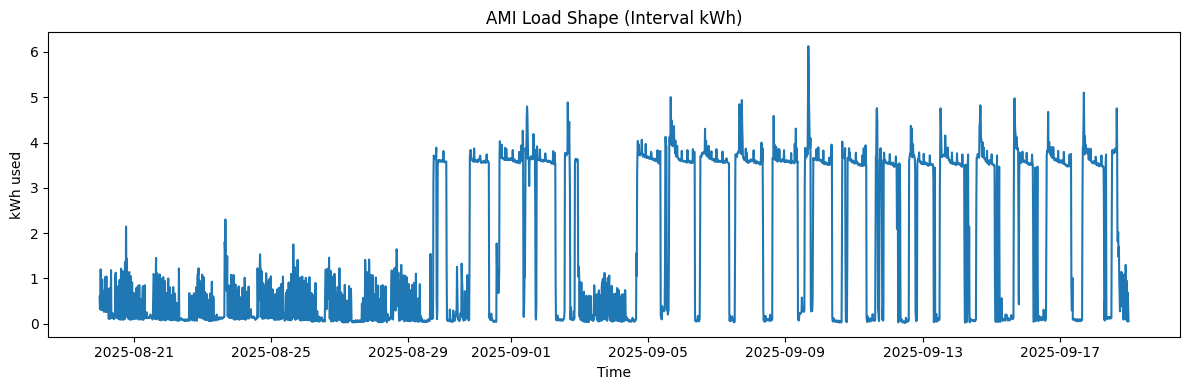

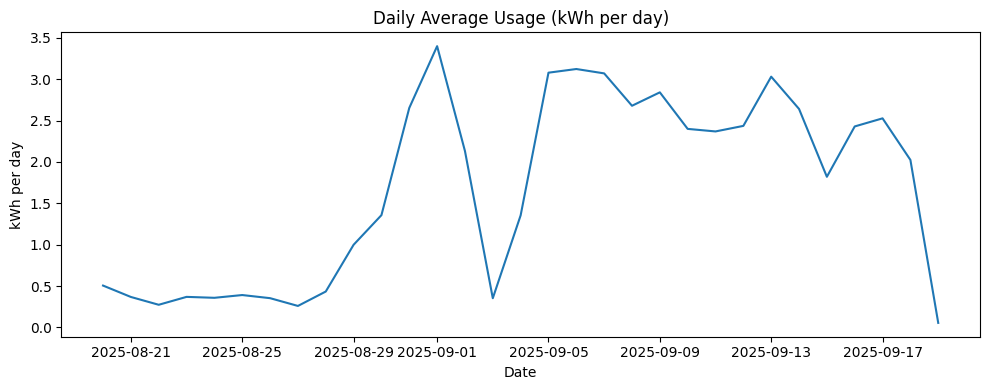

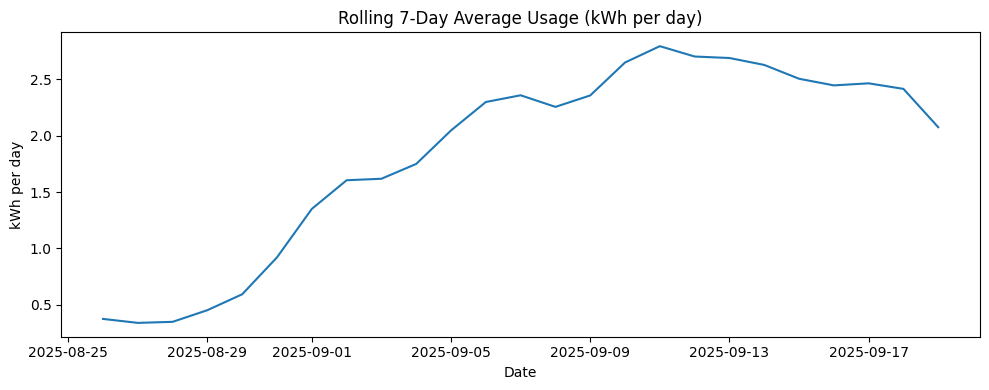

In [ ]:
# Cell 5: Run the full pipeline on your AMI file

# 1. Set your AMI Excel file name (must match what you uploaded in Colab)
ami_file = "AMIdataexample.xlsx"  # <-- change this if your file has a different name

# 2. Quick AMI analysis (optional but good for report)
loader = AMILoader(ami_file)
df_clean = loader.load_and_clean()

features = AMIFeatures(df_clean).compute_features()

print("Interval length:", features["interval_minutes"], "minutes")
print("Base load:", features["base_load_str"])
print("Daily average load:", features["daily_avg_str"])
print("Peak interval usage:", f"{features['peak_usage']:.4f} kWh")

# 3. Build ML dataset
build_ml_dataset(ami_file, "training_data.csv")

# 4. Train ML models (baseline + random forest)
train_models("training_data.csv")


graphs = AMIGraphs(df_clean, features)
graphs.plot_load_shape()
graphs.plot_daily_average()
graphs.plot_rolling_average()
